<a href="https://colab.research.google.com/github/DominikVincent/SpeachSpeakerProject/blob/master/SSR_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/My Drive/Colab Notebooks/SSR_Project

/content/drive/My Drive/Colab Notebooks/SSR_Project


In [2]:
pip install soundfile

In [0]:
import matplotlib.pyplot as plt
import librosa.display as disp
import numpy as np

from data_utils.data_loader import Data_loader, EMO_DICT

import tensorflow as tf
from tensorflow.keras import layers


from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [0]:
dl= Data_loader()
data = dl.load_data()

In [0]:
observed_emotions=['calm', 'happy', 'fearful', 'disgust']
N_observed = 4
EMO_DICT= {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fearful', 6:'disgust', 7:'surprised'}
NR_TO_NR = {1:0, 2:1, 5:2, 6:3}
x = []
y = []
for d in data:
    emot_nr = np.argmax(d['emotion'])
    if EMO_DICT[emot_nr] in observed_emotions:
        x.append(np.hstack((np.mean(d['mfcc'],axis=0), np.mean(d['chroma'],axis=0), np.mean(d['mel'],axis=0))))
        
        y.append(np.eye(N_observed, dtype=np.int32)[NR_TO_NR[emot_nr]-1])
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)


In [0]:
observed_emotions=['calm', 'happy', 'fearful', 'disgust']
N_observed = 4
EMO_DICT= {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fearful', 6:'disgust', 7:'surprised'}
NR_TO_NR = {1:0, 2:1, 5:2, 6:3}
x = []
y = []
for d in data:
    emot_nr = np.argmax(d['emotion'])
    if EMO_DICT[emot_nr] in observed_emotions:      
        x.append(np.hstack((d['mfcc'], d['chroma'], d['mel'])))
        
        y.append(np.eye(N_observed, dtype=np.int32)[NR_TO_NR[emot_nr]-1])
    
# splitt for train
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

## DATA using the CNN 

In [0]:

X_train = np.expand_dims(np.array(X_train), axis=2)
X_test = np.expand_dims(np.array(X_test), axis=2)

y_train, y_test = np.array(y_train), np.array(y_test)

# Normalize
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std



## DATA using LSTM 

In [6]:
# transform lists to numpy arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# pad
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,X_train.shape[1])
# Normalize
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = np.nan_to_num((X_train - mean)/std, nan=0.0)
X_test = np.nan_to_num((X_test - mean)/std, nan=0.0)
Xshape= X_train.shape[2]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [0]:
def get_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(256, 8, padding='same',input_shape=(inputs[train].shape[1],1), name="C1"))  
    model.add(layers.Activation('relu'))

    model.add(layers.Conv1D(256, 8, padding='same', name="C2"))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.MaxPooling1D(pool_size=(8)))

    for i in range(3):
        model.add(layers.Conv1D(128, 8, padding='same', name="C"+str(i+3)))
        model.add(layers.Activation('relu'))

    model.add(layers.Conv1D(128, 8, padding='same', name="C6"))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.MaxPooling1D(pool_size=(8)))

    model.add(layers.Conv1D(64, 8, padding='same', name="C7"))
    model.add(layers.Activation('relu'))

    model.add(layers.Conv1D(64, 8, padding='same', name="C8"))
    model.add(layers.Activation('relu'))
    model.add(layers.Flatten())

    model.add(layers.Dense(4, name="OUT")) # Target class number
    model.add(layers.Activation('softmax'))

    # compile model
    opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model



In [0]:
def LSTM_model():
  model = tf.keras.Sequential()

  # Add a LSTM layer with 300 internal units.
  model.add( tf.keras.layers.LSTM(300, input_shape=(None, 180)))

  # Add a Dense layer with 64 units.
  model.add(layers.Dense(64, kernel_initializer="he_normal"))
  model.add(layers.BatchNormalization())

  model.add(layers.Dense(4, activation='softmax'))

  opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False, clipnorm=1.)
 
  model.compile(loss='categorical_crossentropy', 
                optimizer=opt,
                metrics=['accuracy'])
  return model

In [0]:
inputs = np.concatenate((X_train,X_test))
targets = np.concatenate((y_train,y_test))

In [0]:

seed =7
np.random.seed(seed)
kfold = KFold(n_splits=3, shuffle=True)
tscv = TimeSeriesSplit(n_splits=10)
TimeSeriesSplit(max_train_size=None, n_splits=3)

CV_scores = []
acc_per_fold = []
loss_per_fold = []
fold_no =1


------------------------------------------------------------------------
Training for fold 1 
Score for fold 1: loss of 1.040040373802185; accuracy of 66.40625%
------------------------------------------------------------------------
Training for fold 2 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Score for fold 2: loss of 1.0528095960617065; accuracy of 67.96875%
------------------------------------------------------------------------
Training for fold 3 
Score for fold 3: loss of 0.7538533806800842; accuracy of 67.578125%


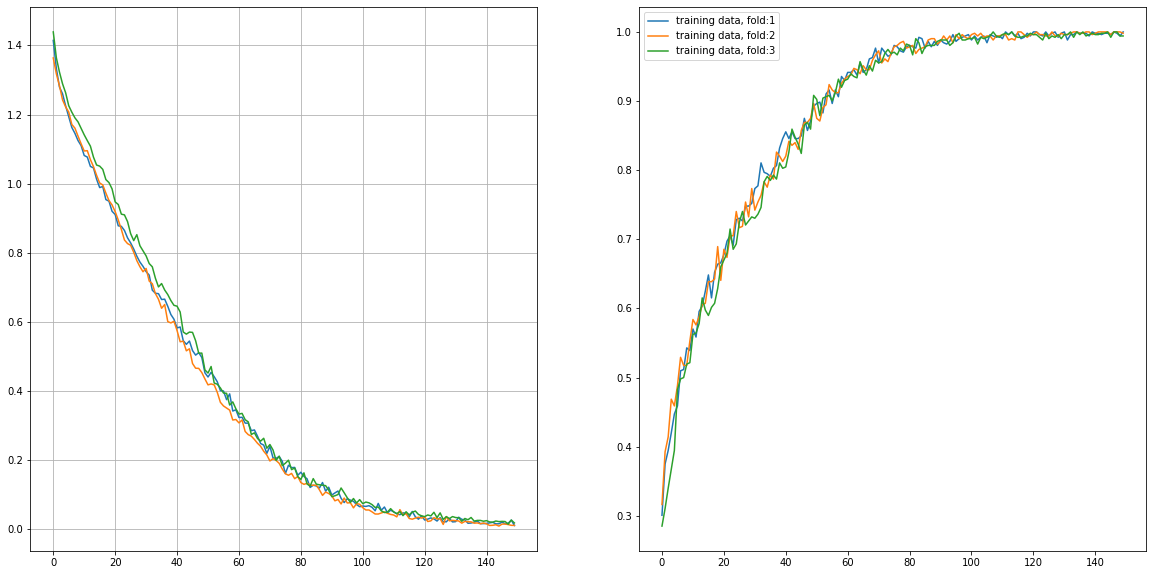

In [10]:
plt.figure(figsize=(20,10))
for train, test in kfold.split(x,y):
    model = get_model()
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ')
    model_history=model.fit(inputs[train], targets[train], batch_size=16, epochs=150, verbose=0)

    # plot
    plt.subplot(121)
    plt.plot(model_history.history['loss'],label="training data, fold:" +str(fold_no))
    plt.grid()
    plt.subplot(122)
    plt.plot(model_history.history['accuracy'],label="training data, fold:" +str(fold_no))
    plt.grid()
    
    #evaluate model
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no+=1
plt.grid()
plt.legend()
plt.show()       

In [13]:
av_loss = np.mean(loss_per_fold)
av_acc = np.mean(acc_per_fold) 
print("Kfold average:\n loss:", av_loss, "\n accuracy:", av_acc)

Kfold average:
 loss: 0.8426877379417419 
 accuracy: 73.6978805065155


------------------------------------------------------------------------
Training for fold 1 
Epoch 1/30
5/5 [==============================] - 0s 52ms/step - loss: 1.6733 - accuracy: 0.3590
Epoch 2/30
5/5 [==============================] - 0s 43ms/step - loss: 1.2044 - accuracy: 0.5000
Epoch 3/30
5/5 [==============================] - 0s 39ms/step - loss: 1.0247 - accuracy: 0.6154
Epoch 4/30
5/5 [==============================] - 0s 38ms/step - loss: 0.8598 - accuracy: 0.7051
Epoch 5/30
5/5 [==============================] - 0s 38ms/step - loss: 0.7679 - accuracy: 0.6667
Epoch 6/30
5/5 [==============================] - 0s 39ms/step - loss: 0.7027 - accuracy: 0.7692
Epoch 7/30
5/5 [==============================] - 0s 38ms/step - loss: 0.6469 - accuracy: 0.7051
Epoch 8/30
5/5 [==============================] - 0s 39ms/step - loss: 0.6250 - accuracy: 0.7949
Epoch 9/30
5/5 [==============================] - 0s 39ms/step - loss: 0.5104 - accuracy: 0.8590
Epoch 10/30
5/5 [================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


Score for fold 2: loss of 1.3001397848129272; accuracy of 49.275362491607666%
------------------------------------------------------------------------
Training for fold 3 
Epoch 1/30
14/14 [==============================] - 1s 45ms/step - loss: 1.6903 - accuracy: 0.2500
Epoch 2/30
14/14 [==============================] - 1s 44ms/step - loss: 1.2244 - accuracy: 0.4167
Epoch 3/30
14/14 [==============================] - 1s 45ms/step - loss: 1.0225 - accuracy: 0.5370
Epoch 4/30
14/14 [==============================] - 1s 44ms/step - loss: 0.8914 - accuracy: 0.6065
Epoch 5/30
14/14 [==============================] - 1s 46ms/step - loss: 0.8811 - accuracy: 0.6620
Epoch 6/30
14/14 [==============================] - 1s 45ms/step - loss: 0.7951 - accuracy: 0.6528
Epoch 7/30
14/14 [==============================] - 1s 45ms/step - loss: 0.6926 - accuracy: 0.7315
Epoch 8/30
14/14 [==============================] - 1s 44ms/step - loss: 0.7175 - accuracy: 0.6944
Epoch 9/30
14/14 [==================

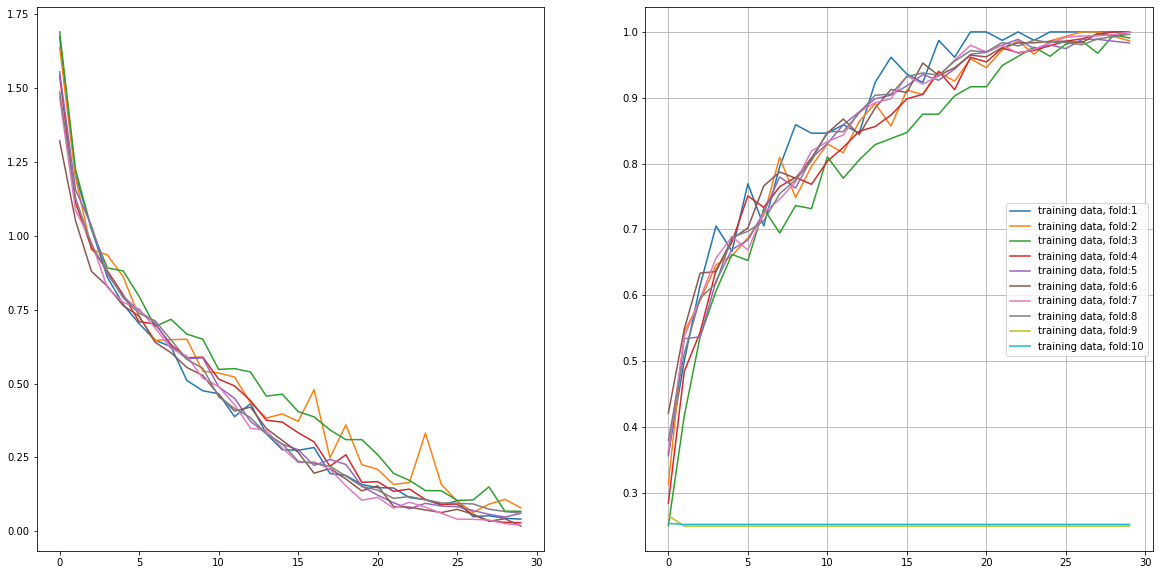

In [10]:
plt.figure(figsize=(20,10))
for train, test in tscv.split(x,y):
    
    model = LSTM_model()
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ')
    model_history=model.fit(inputs[train], targets[train], batch_size=16, epochs=30)

    # plot
    plt.subplot(121)
    plt.plot(model_history.history['loss'],label="training data, fold:" +str(fold_no))
    plt.grid()
    plt.subplot(122)
    plt.plot(model_history.history['accuracy'],label="training data, fold:" +str(fold_no))
    plt.grid()
    

    #evaluate model
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no+=1
plt.grid()
plt.legend()
plt.show()       

In [11]:
av_loss = np.mean(loss_per_fold)
av_acc = np.mean(acc_per_fold) 
print("Kfold average:\n loss:", av_loss, "\n accuracy:", av_acc)

Kfold average:
 loss: nan 
 accuracy: 52.02898532152176
